# Introduction

The preprocessing of the California Fire Perimeters dataset involved several crucial steps, from data acquisition and format conversion to spatial filtering and visualization, providing valuable insights into wildfire patterns, particularly within the Los Angeles city boundary.

**Data Acquisition and Preparation:**

* The **California Fire Perimeters dataset**, sourced from CAL FIRE, was successfully downloaded as a GeoJSON file. This dataset covers fires across California back to 1878 and is updated annually.
* The GeoJSON data was then converted to a CSV format and subsequently loaded into a **GeoDataFrame** for efficient spatial operations. The initial statewide dataset contains 22,810 records with 22 columns, encompassing fire details from 1878 to 2025.

**Spatial Filtering and Clipping for Los Angeles:**

* The **Los Angeles city boundary** was downloaded and used as a spatial reference.
* Two distinct spatial operations were performed on the California fire data relative to the Los Angeles city boundary:
    * **Filtering by Intersection:** This operation identified 458 fire perimeters that **intersected** with (i.e., touched or overlapped) the Los Angeles city boundary. The resulting "unclipped" fires show the full extent of these perimeters, some of which extend significantly outside the city limits.
    * **Clipping:** This operation precisely cut the fire perimeters to only include the portions that fall strictly **within** the Los Angeles city boundary. The "clipped" fires visually represent only the burnt areas inside the city, providing a more accurate view of the direct impact within the urban area.

**Insights from Visualizations:**

* **Original vs. Clipped Comparison:** Visualizations clearly demonstrate the difference between the "unclipped" fires (showing their full extent even if partially outside the boundary) and the "clipped" fires (showing only the portions within the boundary). This highlights the importance of choosing the appropriate spatial operation (intersection versus clipping) based on the analytical objective.
* **Grouping by Year:** Fires were color-coded by their 'YEAR\_' of occurrence, allowing for a chronological visual analysis of fire activity around and within Los Angeles. The range of years for fires intersecting LA spans from 1878 to 2025, with unique values observed for each year.
* **Grouping by Agency:** Visualizing fires by the responsible 'AGENCY' reveals which entities manage or respond to fires in and around the Los Angeles area, such as CCO (Contract County), CDF (CAL FIRE), LRA (Local Responsibility Area), NPS (National Park Service), and USF (US Forest Service).
* **Grouping by Cause:** The 'CAUSE' attribute categorizes fires (e.g., lightning, equipment use, smoking), providing insights into common ignition sources in the region. The scale of causes ranges from 2 to 14, suggesting various contributing factors.

**Data Characteristics and Limitations:**

* The dataset provides detailed attributes for each fire, including 'OBJECTID', 'FIRE\_NAME', 'GIS\_ACRES', and 'ALARM\_DATE'.
* The official data description from CAL FIRE clarifies the criteria for data collection (e.g., fires $\ge$ 10 acres in timber, $\ge$ 50 acres in brush, or $\ge$ 300 acres in grass, and/or $\ge$ 3 damaged/destroyed residential or commercial structures, and/or caused $\ge$ 1 fatality).
* It also highlights **discrepancies with the CAL FIRE Redbook Large Damaging Fires**, enumerating specific historical fires missing from the digital perimeter data.

# Import libraries

In [2]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Read the `CSV` and make plots

In [3]:
def read_geo_df(path: str):
    df = pd.read_csv(path)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs("EPSG:4326", inplace=True)
    return df, gdf

def print_df_info(df, name):
    print(f"--- Info for {name} ---")
    print("Dimensions:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique YEAR_ values:", df['YEAR_'].unique())
    print()

In [4]:
ca_fire_0_df, ca_fire_0_gdf = read_geo_df("california_fire_perimeters_0.csv")
print_df_info(ca_fire_0_gdf, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (22810, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2024. 2023. 2022. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014.
 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002.
 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1994. 1993. 1992. 1991. 1990.
 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979. 1978.
 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967. 1966.
 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955. 1954.
 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1945. 1944. 1943. 1942.
 1941. 1940. 1939. 1938. 1937. 1936. 1935. 1934. 1933. 1932. 1931. 1930.
 1929. 1928. 1927. 1926. 1925. 1924. 1923. 1922. 1921. 1920. 1

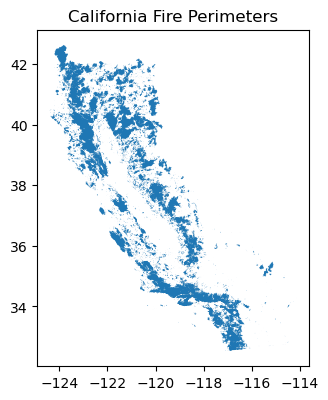

In [5]:
ca_fire_0_gdf.plot(figsize=(3.5, 5))
plt.title("California Fire Perimeters")
plt.show()

# Extract fires only happened inside the Los Angeles city boundary

In [6]:
def filter_fires_in_boundary(fire_gdf, boundary_gdf, mode="within"):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    boundary_union = boundary_gdf.geometry.union_all()
    
    if mode == "within":
        filtered_fires = fire_gdf[fire_gdf.geometry.within(boundary_union)]
    elif mode == "intersects":
        filtered_fires = fire_gdf[fire_gdf.geometry.intersects(boundary_union)]
    else:
        raise ValueError("mode must be 'within' or 'intersects'")
    
    return filtered_fires

def fix_invalid_geometries(gdf):
    # Attempt to fix invalid geometries using buffer(0)
    gdf['geometry'] = gdf.geometry.buffer(0)
    # Drop any that remain invalid (optional)
    gdf = gdf[gdf.is_valid]
    return gdf

def clip_fires_to_boundary(fire_gdf, boundary_gdf):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    fire_gdf = fix_invalid_geometries(fire_gdf)
    
    boundary_union = boundary_gdf.geometry.union_all()
    clipped_fires = gpd.clip(fire_gdf, boundary_union)
    return clipped_fires

<Axes: >

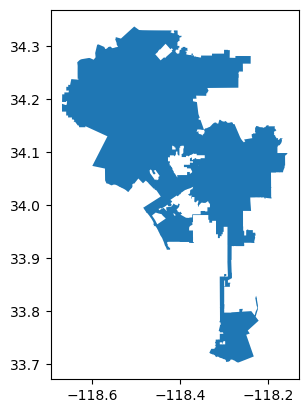

In [7]:
la_boundary = gpd.read_file('la_city_boundary.geojson')
la_boundary.plot()

In [8]:
# Filter out the fires around and inside the LA city boundary
la_fire_0_gdf = filter_fires_in_boundary(ca_fire_0_gdf, la_boundary, mode="intersects")
print_df_info(la_fire_0_gdf, "ca_fire_0_df")

# Clip the fires that are strictly inside the LA city
la_fire_0_gdf_clipped = clip_fires_to_boundary(ca_fire_0_gdf, la_boundary)
print_df_info(la_fire_0_gdf_clipped, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014. 2013. 2012. 2010.
 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2000. 1999. 1994. 1993. 1992.
 1991. 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979.
 1978. 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967.
 1966. 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955.
 1954. 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1944. 1943. 1942.
 1941. 1938. 1937. 1935. 1933. 1932. 1929. 1927. 1925. 1924. 1923. 1922.
 1921. 1919. 1918. 1916. 1915. 1914. 1913. 1911. 1910. 1878.]

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 

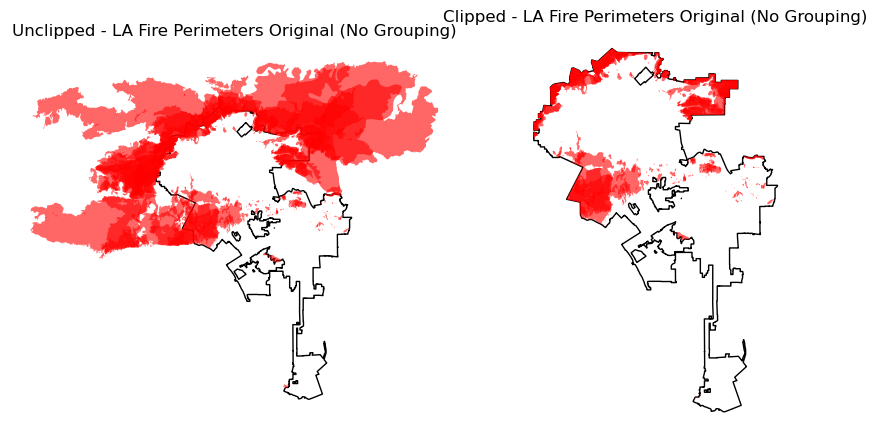

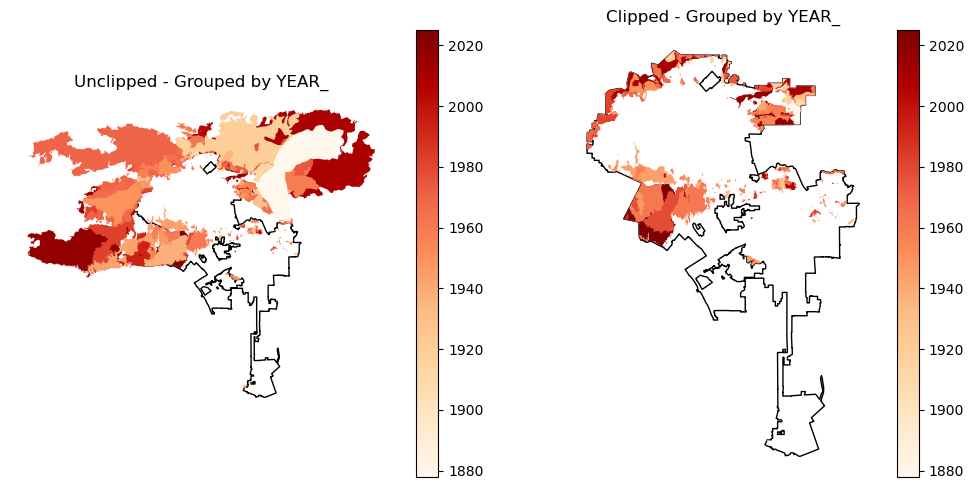

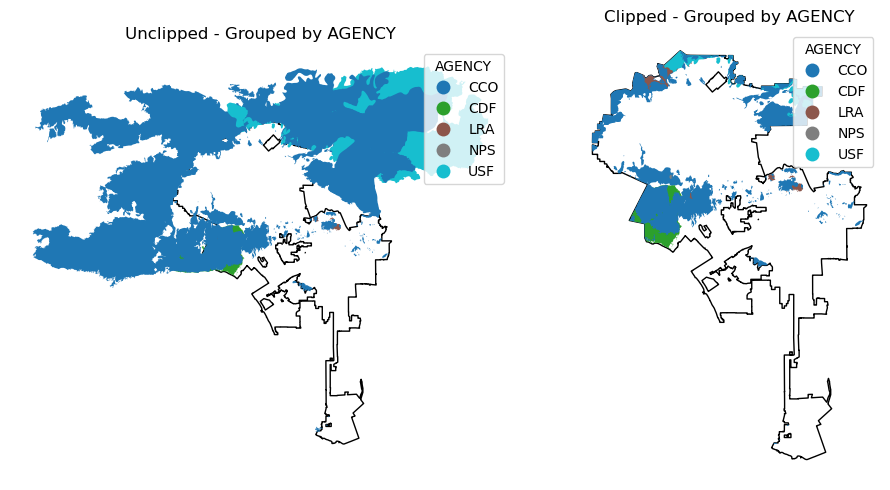

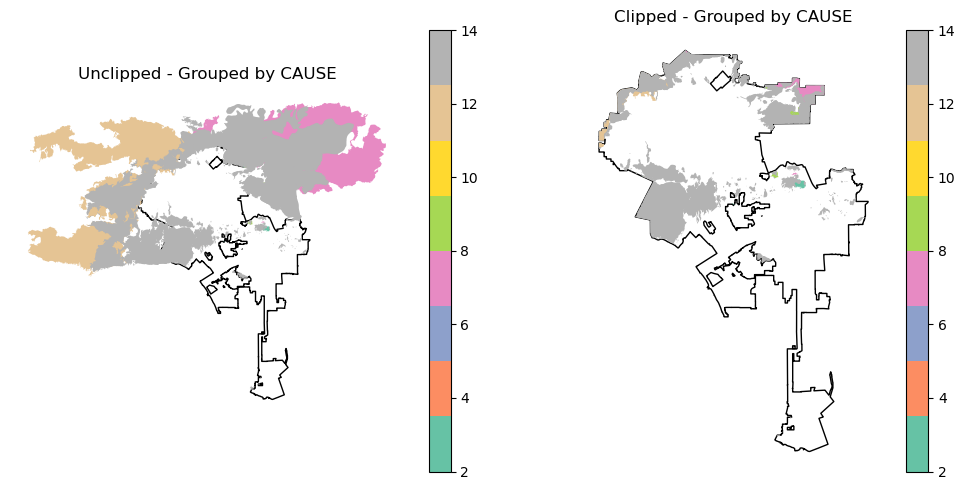

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

# Unclipped original
la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
la_fire_0_gdf.plot(ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Unclipped - LA Fire Perimeters Original (No Grouping)')
axes[0].axis('off')

# Clipped original
la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
la_fire_0_gdf_clipped.plot(ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Clipped - LA Fire Perimeters Original (No Grouping)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

group_cols = ['YEAR_', 'AGENCY', 'CAUSE']
colormaps = ['OrRd', 'tab10', 'Set2']

for group_col, cmap in zip(group_cols, colormaps):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    col_dtype = la_fire_0_gdf[group_col].dtype
    is_categorical = is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype)

    legend_args = {'legend': True}
    if is_categorical:
        legend_args['legend_kwds'] = {'title': group_col}

    # Unclipped plot
    la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
    la_fire_0_gdf.plot(
        ax=axes[0],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[0].set_title(f'Unclipped - Grouped by {group_col}')
    axes[0].axis('off')

    # Clipped plot
    la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
    la_fire_0_gdf_clipped.plot(
        ax=axes[1],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[1].set_title(f'Clipped - Grouped by {group_col}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Take a close look to the LA only data

In [10]:
print(la_fire_0_gdf)

       OBJECTID   YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  \
0             1  2025.0    CA    CDF     LDF  PALISADES  00000738   
4             5  2025.0    CA    CDF     LDF      HURST  00003294   
1175       1177  2021.0    CA    LRA     LAC  PALISADES  00001448   
1518       1520  2021.0    CA    LRA     LDF       PEAK  00001026   
1972       1974  2020.0    CA    CCO     LAC    TOPANGA  00216968   
...         ...     ...   ...    ...     ...        ...       ...   
22265     22267  1913.0    CA    USF     ANF             00000000   
22428     22430  1911.0    CA    USF     ANF             00000000   
22607     22609  1910.0    CA    USF     ANF             00000000   
22638     22640  1910.0    CA    USF     ANF             00000000   
22732     22734  1878.0    CA    CCO     LAC             00000000   

         ALARM_DATE     CONT_DATE  CAUSE  ...     GIS_ACRES  \
0      1.736237e+12  1.738310e+12     14  ...  23448.880000   
4      1.736237e+12  1.736410e+12     14  ...

In [11]:
la_fire_0_gdf

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,1.736237e+12,1.738310e+12,14,...,23448.880000,NaN,NaN,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},NaN,NaN,2020-January 2025,1.386518e+08,140231.608232,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198..."
4,5,2025.0,CA,CDF,LDF,HURST,00003294,1.736237e+12,1.736410e+12,14,...,831.385500,NaN,NaN,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},NaN,NaN,2020-January 2025,4.946082e+06,16094.217073,"POLYGON ((-118.46974 34.33079, -118.46964 34.3..."
1175,1177,2021.0,CA,LRA,LAC,PALISADES,00001448,1.621062e+12,1.621580e+12,14,...,1202.648000,NaN,NaN,NaN,NaN,NaN,2020-January 2025,7.115175e+06,19990.114323,"POLYGON ((-118.56487 34.08733, -118.56485 34.0..."
1518,1520,2021.0,CA,LRA,LDF,PEAK,00001026,1.626764e+12,1.626764e+12,10,...,1.283047,NaN,NaN,{561B9D97-7776-41F4-9CCF-7314209A8655},NaN,NaN,2020-January 2025,7.621836e+03,374.381936,"POLYGON ((-118.63199 34.2698, -118.63199 34.26..."
1972,1974,2020.0,CA,CCO,LAC,TOPANGA,00216968,1.595401e+12,1.595401e+12,11,...,2.614254,NaN,NaN,NaN,NaN,NaN,2020-January 2025,1.548140e+04,693.288839,"POLYGON ((-118.5823 34.13759, -118.5823 34.137..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22265,22267,1913.0,CA,USF,ANF,,00000000,-1.776704e+12,NaN,14,...,7016.843000,NaN,NaN,NaN,NaN,NaN,1950-1959,4.168664e+07,29675.914839,"POLYGON ((-118.25198 34.29917, -118.2508 34.29..."
22428,22430,1911.0,CA,USF,ANF,,00000000,NaN,NaN,14,...,745.726600,"S.Imsand,Tujunga,3N15W-20,29,Sombrero Cyn & W-...",NaN,NaN,00000000,NaN,1950-1959,4.435870e+06,9851.900107,"POLYGON ((-118.48053 34.33132, -118.47926 34.3..."
22607,22609,1910.0,CA,USF,ANF,,00000000,NaN,NaN,14,...,445.926300,"S Imsand,Tujunga, 2N 13W-17, bet.Haines&Cooks...",NaN,NaN,00000000,NaN,1950-1959,2.648059e+06,6144.544734,"POLYGON ((-118.26437 34.24786, -118.26514 34.2..."
22638,22640,1910.0,CA,USF,ANF,,00000000,NaN,NaN,14,...,57.611500,"S Imsand,Tujunga, 2N 14W-1, NW Big Tujunga Ca...",NaN,NaN,00000000,NaN,1950-1959,3.423284e+05,2152.393819,"POLYGON ((-118.30635 34.27869, -118.30713 34.2..."


In [39]:
la_fire_0_gdf_clipped

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
18476,18478,1942.0,CA,CCO,LAC,COAST NO. 255,00000000,-8.574048e+11,NaN,14,...,145.80970,NaN,NaN,NaN,00000000,NaN,1950-1959,8.553569e+05,7627.337667,"POLYGON ((-118.32305 33.72922, -118.32334 33.7..."
15287,15289,1963.0,CA,CCO,LAC,,00000000,-2.067300e+11,NaN,14,...,28.42875,NaN,NaN,NaN,00000000,NaN,1960-1969,1.667814e+05,2170.128424,"MULTIPOLYGON (((-118.32028 33.73546, -118.3203..."
16885,16887,1953.0,CA,CCO,LAC,,00000000,-5.223492e+11,NaN,14,...,15.26304,NaN,NaN,NaN,00000000,NaN,1950-1959,8.955474e+04,1334.581520,"POLYGON ((-118.30917 33.74115, -118.30934 33.7..."
13547,13549,1975.0,CA,CCO,LAC,,00000000,1.729116e+11,NaN,14,...,11.51992,NaN,NaN,NaN,00000000,NaN,1970-1979,6.761827e+04,1075.296277,"POLYGON ((-118.30103 33.75769, -118.3011 33.75..."
17964,17966,1946.0,CA,CCO,LAC,,00000000,-7.443972e+11,NaN,14,...,75.99637,NaN,NaN,NaN,00000000,NaN,1950-1959,4.486323e+05,4049.161789,"MULTIPOLYGON (((-118.34259 34.00472, -118.3424..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,12550,1980.0,CA,CCO,LAC,,00000000,NaN,NaN,14,...,6.57405,NaN,NaN,NaN,00000000,NaN,1980-1989,3.905667e+04,732.762211,"POLYGON ((-118.33474 34.27367, -118.335 34.273..."
20916,20918,1923.0,CA,USF,ANF,WELLS,00000000,-1.470589e+12,NaN,14,...,16.34873,"S.Imsand, Tujunga, 2N 14W-12,S side Big Tujung...",NaN,NaN,00000000,NaN,1950-1959,9.713375e+04,1138.387685,"POLYGON ((-118.2985 34.27548, -118.29889 34.27..."
12397,12399,1980.0,CA,CCO,LAC,FOOTHILL,00316027,3.431232e+11,NaN,14,...,267.41720,NaN,NaN,NaN,00004175,NaN,1980-1989,1.588842e+06,5816.683587,"POLYGON ((-118.33443 34.28157, -118.33404 34.2..."
20875,20877,1923.0,CA,USF,ANF,FITZGERALD,00000000,-1.463072e+12,NaN,14,...,164.67840,"S.Imsand, Tujunga, 2N 14W-12+2N13W-7,SE slope ...",NaN,NaN,00000000,NaN,1950-1959,9.784550e+05,4028.931067,"POLYGON ((-118.29707 34.27383, -118.29783 34.2..."


In [19]:
la_fire_0_gdf.to_csv("la_fire_0_gdf.csv", index=False)

In [12]:
df_trees = pd.read_csv("la_trees_combined.csv")

In [13]:
df_trees

,Latitude,Longitude,Species,DBH,Any_Protected
0,34.057989,-118.316354,velvet ash; Arizona ash (Fraxinus velutina),17.0,False
1,34.057987,-118.316122,ash species (Fraxinus spp.),21.0,False
2,34.057984,-118.316252,ash species (Fraxinus spp.),21.0,False
3,34.057924,-118.316600,majesty palm (Ravenea rivularis),7.0,False
4,34.057840,-118.316591,queen palm (Syagrus romanzoffiana),11.0,False
...,...,...,...,...,...
848189,34.281487,-118.524730,swamp mallee (Eucalyptus spathulata),1.0,False
848190,34.281391,-118.524696,swamp mallee (Eucalyptus spathulata),1.0,False
848191,34.281378,-118.524487,swamp mallee (Eucalyptus spathulata),1.0,False
848192,34.281584,-118.524269,swamp mallee (Eucalyptus spathulata),1.0,False


In [40]:
gdf_fire = la_fire_0_gdf_clipped.copy()

# Visualization Trees and Fires 

/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_75709/1006968694.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


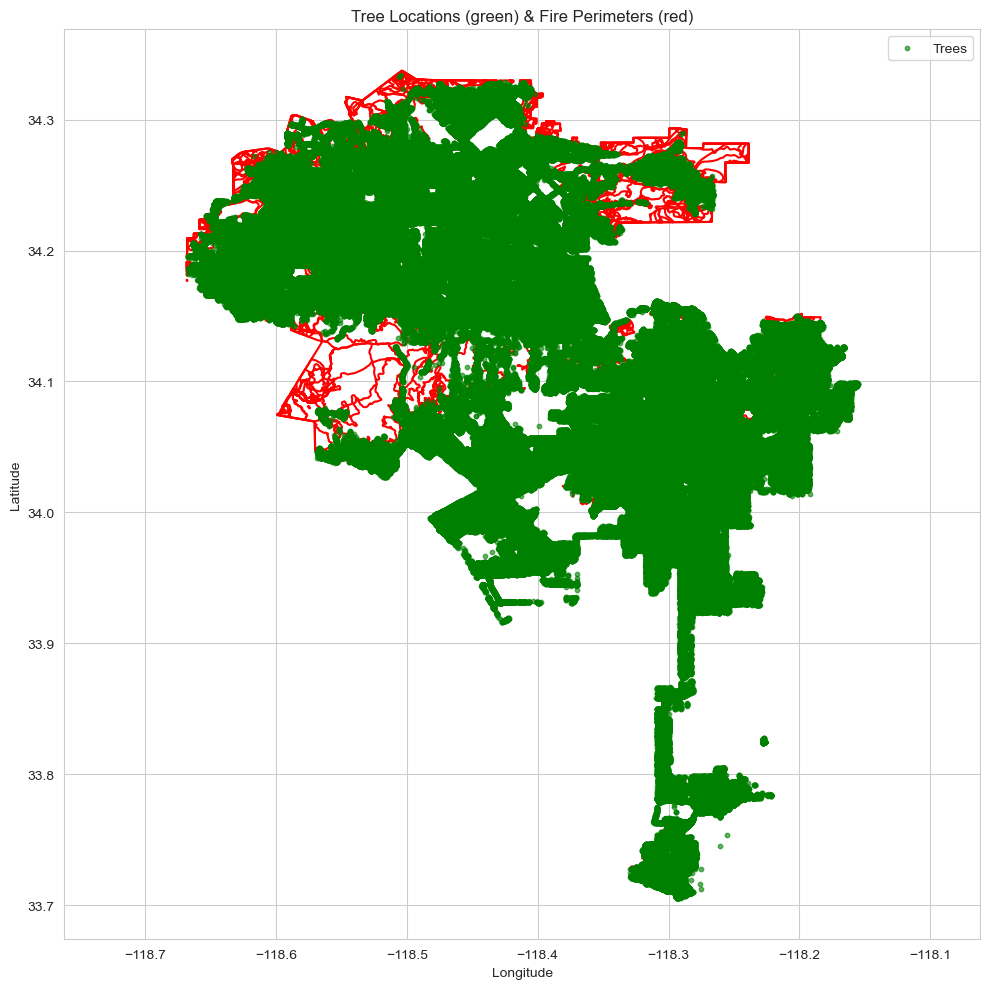

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt

# (Re-)create your GeoDataFrames if needed:
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Fire perimeters in red, no fill
gdf_fire.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=1.5,
    label="Fire Perimeters"
)

# Trees in green dots
gdf_trees.plot(
    ax=ax,
    marker="o",
    color="green",
    markersize=10,
    alpha=0.6,
    label="Trees"
)

# Legend and labels
ax.legend(loc="upper right")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Tree Locations (green) & Fire Perimeters (red)")
ax.axis("equal")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:465: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:467: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title=self.legend_title)
/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_75709/2493478484.py:56: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Within Fire?")


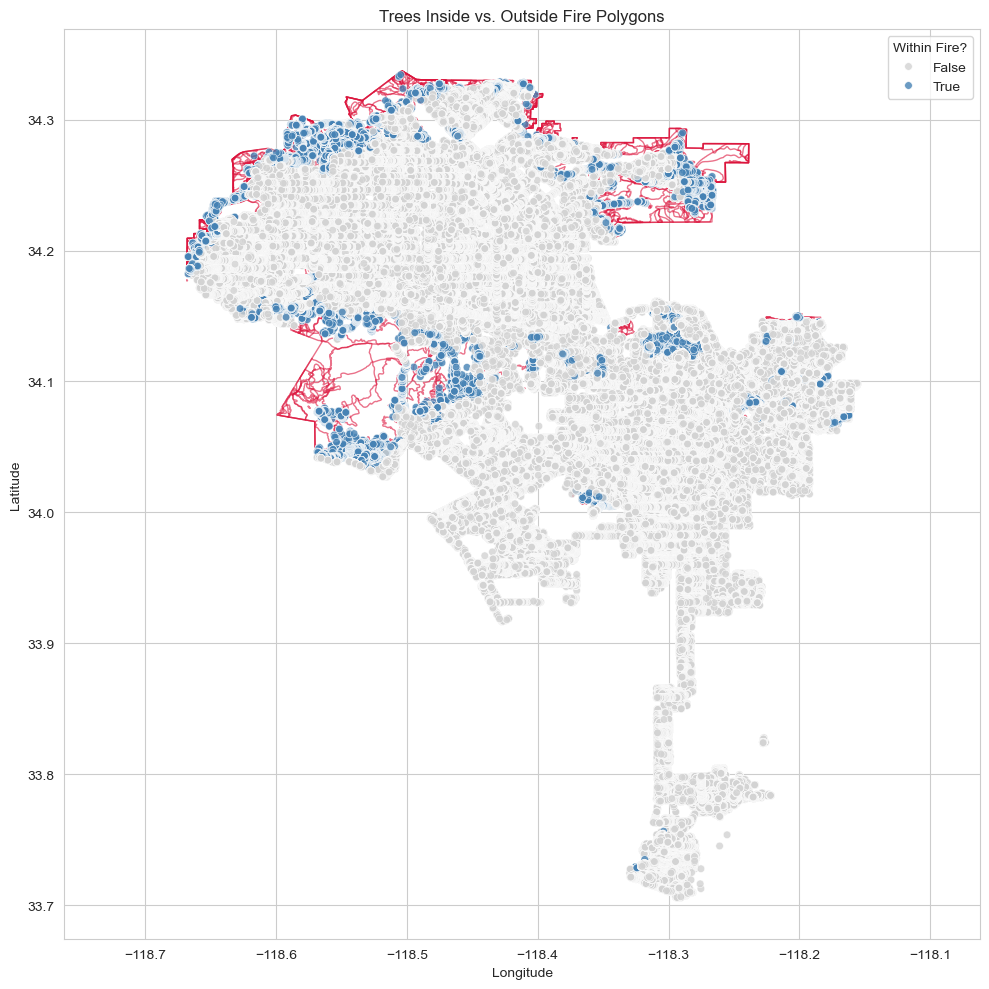

In [47]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# — 1. Build your GeoDataFrames (WGS84) —
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# — 2. Spatial‐join trees → fires (point within polygon) —
joined = gpd.sjoin(
    gdf_trees,
    gdf_fire[['geometry']],
    how="left",             # keep all trees
    predicate="within"      # tree point within fire polygon
)

# — 3. Find which tree‐indices had a match —
inside_idx = joined.loc[joined['index_right'].notna(), :].index.unique()

# — 4. Make a boolean column on the original trees —
gdf_trees['in_fire'] = gdf_trees.index.isin(inside_idx)

# — 5. Plot with Seaborn —
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))

# Fire perimeters underneath
gdf_fire.plot(
    ax=ax,
    facecolor="none",
    edgecolor="crimson",
    linewidth=1,
    alpha=0.6,
    label="Fire Perimeter"
)

# Trees: outside in gray, inside in blue
sns.scatterplot(
    data=gdf_trees,
    x="Longitude", y="Latitude",
    hue="in_fire",
    palette={False:"lightgray", True:"steelblue"},
    s=30, alpha=0.8,
    ax=ax,
    legend="brief"
)

ax.set_title("Trees Inside vs. Outside Fire Polygons")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.axis("equal")
plt.legend(title="Within Fire?")
plt.tight_layout()
plt.show()


In [48]:
# Total number of trees
total_trees = len(gdf_trees)

# Number of trees within a fire
trees_in_fire = gdf_trees['in_fire'].sum()

print(f"{trees_in_fire} out of {total_trees} trees fall within a fire perimeter.")

55013 out of 848194 trees fall within a fire perimeter.


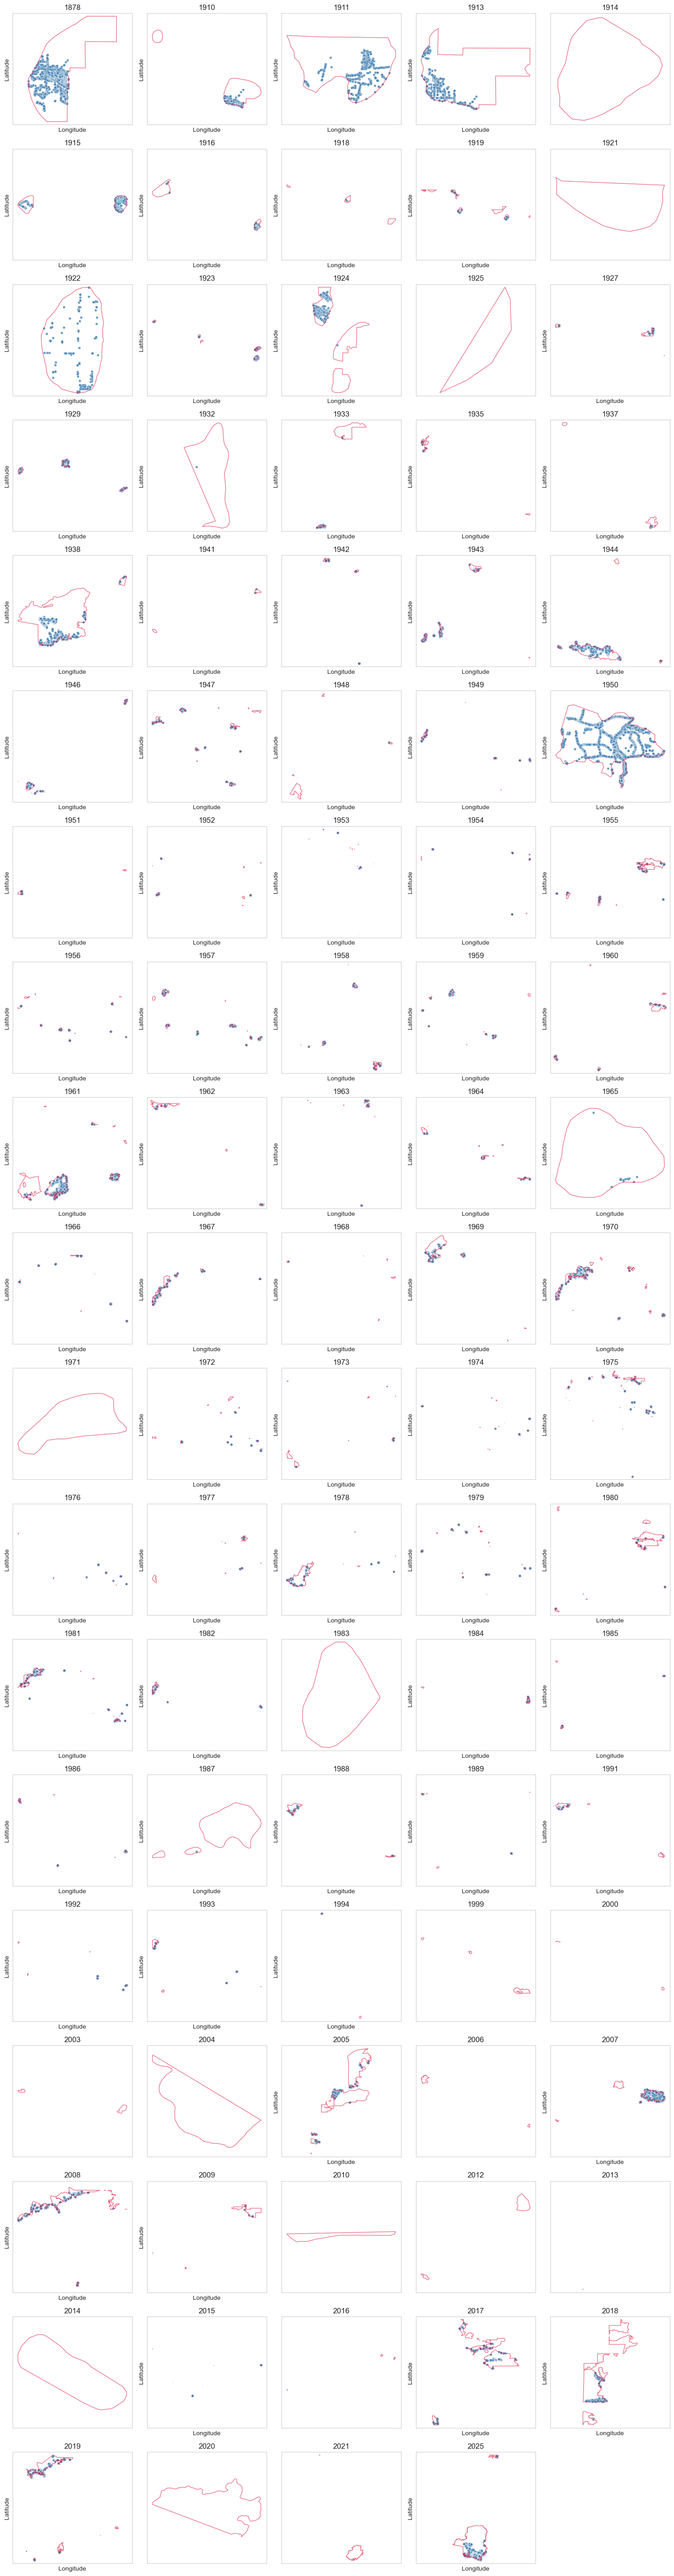

In [43]:
import math
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Build your GeoDataFrames (WGS84)
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# 2. Spatial‐join to tag each tree with the YEAR_ of the fire it falls in
joined = gpd.sjoin(
    gdf_trees,
    gdf_fire[['YEAR_','geometry']],
    how='inner',
    predicate='within'
)

# 3. Unique years present in your fire data
years = sorted(gdf_fire['YEAR_'].dropna().unique())

# 4. Setup subplot grid
n = len(years)
ncols = 5
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
axes = axes.flatten()

# 5. Loop over each year
sns.set_style("whitegrid")
for ax, year in zip(axes, years):
    # 5a. Plot that year's fire perimeters (just the boundaries)
    gdf_fire[gdf_fire['YEAR_']==year].boundary.plot(
        ax=ax,
        edgecolor='crimson',
        linewidth=1,
        alpha=0.6
    )
    
    # 5b. Find trees that joined to that year
    tree_idxs = joined[joined['YEAR_']==year].index
    subset = gdf_trees.loc[tree_idxs]
    
    # 5c. Plot those trees with seaborn
    sns.scatterplot(
        x=subset['Longitude'],
        y=subset['Latitude'],
        ax=ax,
        s=15,
        color='steelblue',
        alpha=0.8,
        legend=False
    )
    
    ax.set_title(f"{int(year)}")
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# 6. Remove extra axes
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [49]:
# 1. Add a unique ID to each tree
df_trees['tree_id'] = range(len(df_trees))

# 2. Build the tree GeoDataFrame (now contains tree_id)
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)

# 3. Ensure fires have the same CRS
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# 4. Spatial-join: attach fire attributes to each tree within a fire
gdf_merged = gpd.sjoin(
    gdf_trees,
    gdf_fire,
    how="inner",
    predicate="within"
).reset_index(drop=True)

# Now gdf_merged has a column 'tree_id' you can use to trace back each original tree
gdf_merged

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,1.0,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419
3,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),17346,17348,1950.0,...,1.0,4233.7710,NaN,NaN,NaN,00000000,NaN,1950-1959,2.516131e+07,31893.552189
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,1.0,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92763,34.281985,-118.524873,swamp mallee (Eucalyptus spathulata),1.0,False,848183,POINT (-118.52487 34.28199),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92764,34.281909,-118.524855,cork oak (Quercus suber),1.0,False,848184,POINT (-118.52486 34.28191),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92765,34.281829,-118.524832,cork oak (Quercus suber),1.0,False,848185,POINT (-118.52483 34.28183),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92766,34.281753,-118.524804,cork oak (Quercus suber),1.0,False,848186,POINT (-118.5248 34.28175),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800


In [50]:
len(gdf_merged["tree_id"].unique())

55013

In [36]:
gdf_merged["YEAR_"].unique()

array([1944., 1959., 1950., 1960., 1961., 1955., 1947., 2008., 1981.,
       1970., 1952., 1943., 2025., 1927., 1878., 1942., 1924., 2019.,
       1956., 1958., 1929., 2009., 1975., 1954., 2017., 1938., 1967.,
       1976., 1922., 1913., 1916., 1982., 1911., 1946., 1923., 1979.,
       1985., 1972., 1957., 1969., 1915., 1980., 1964., 1935., 1966.,
       1949., 1919., 1984., 1978., 1986., 1910., 1951., 2005., 1993.,
       1991., 1962., 1932., 1988., 1994., 1953., 1941., 1937., 1973.,
       1992., 1918., 1963., 1933., 1974., 1948., 2018., 2007., 1977.,
       2015., 1989., 1965., 1968., 1987.])